# Serious Accident Prediction with PySpark and Sci-Kit Learn

The cells in this notebook allow users to train and validate machine learning models with [sci-kit learn](http://scikit-learn.org/stable/) based on sample training data extracted from the SafeRoad data grid for collisions and non-collisions from between July 2012 and December 2015 and a sample validation set for data between December 2015 and March 2016.

In [1]:
#Scikit learn libraries
#classifiers
from sklearn.ensemble import RandomForestClassifier

#metrics/cross-validation
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, r2_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

#Python Libraries
import sys
#sys.path.append('../Infrastructure_Capstone')
import os
import random
from copy import deepcopy
from pyproj import Proj
import datetime as dt
from dateutil.parser import parse
import numpy as np
import pandas as pd

import ConfigParser
import time
import datetime as dt
from itertools import combinations
from elasticsearch import Elasticsearch, helpers


%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#get Elasticsearch connection information from config file
config = ConfigParser.ConfigParser()
config.read('/root/Infrastructure_Capstone/config/capstone_config.ini')

ES_url = config.get('ElasticSearch','host')
ES_hosts = config.get('ElasticSearch','hostlist')
ES_password = config.get('ElasticSearch','password')
ES_username= config.get('ElasticSearch','username')

data_grid = config.get('indexes','grid')
results = config.get('indexes','results')
update = config.get('indexes','pred_update')
features = config.get('indexes','features')
diag = config.get('indexes','diagnostics')
collisions_idx = config.get('indexes','collisions')

print data_grid
sns.set(font_scale=1.3)
seed = random.seed(0)

nyc_grid/rows


### Read Data from Elasticsearch

This cell defines the read configurations for the Hadoop-Elasticsearch plugin to read data directly from Elasticsearch into a Spark RDD of the format (key, {json document}) for each document in the index. Change the "es.resource" field to switch between different index/doc_types in Elasticsearch.

In [2]:
#Configuration for reading from and writing to Elasticsearch
es_read_conf = { 
        "es.resource" : data_grid, 
        "es.nodes" : ES_hosts,
        "es.port" : "9200",
        "es.net.http.auth.user" : ES_username,
        "es.net.http.auth.pass" : ES_password
    }

pred_read_conf = { 
        "es.resource" : results, 
        "es.nodes" : ES_hosts,
        "es.port" : "9200",
        "es.net.http.auth.user" : ES_username,
        "es.net.http.auth.pass" : ES_password
    }

### Training Points
 
The following function builds the feature arrays for the ML algorithm.

In [3]:
def trainingDict(row,victim='all'):
    #returns a dict of label and features for an ML algorithm, victim type to set as the truth label
    #input: SparkSQL dataframe row element
    #output: Dict of label and features (1=any injury/fatality 0=no injury/fatality) for training
    #id field
    if 'median_speed_limit' in row:
        #only keep records with street information
        output = {}

        output['id'] = row['grid_id']

        #zip code
        output['zipcode'] = row['grid_zipcode']

        #date time fields
        output['dayOfMonth'] = long(row['grid_day'])
        output['dayOfWeek'] = long(row['grid_dayOfWeek'])
        output['hour'] = long(row['grid_hourOfDay'])
        output['month'] = long(row['grid_month'])

        #weather fields
        output['fog'] = row['weather_Fog_Dummy']
        output['rain'] = row['weather_Rain_Dummy']
        output['snow'] = row['weather_SnowHailIce_Dummy']

        output['temp'] = row['weather_WetBulbFarenheit']
        output['precip'] = row['weather_HourlyPrecip']
        #vis = row.weather_Visibility  ## NOT AVAILABLE IN WEATHER FORECAST
        output['windspeed'] = row['weather_WindSpeed']

        #zipcode-specific data
        output['zip_area'] = row['zip_area']
        output['speed5'] = row["5mph"]
        output['speed15'] = row["15mph"]
        output['speed25'] = row["25mph"]
        output['speed35'] = row["35mph"]
        output['speed45'] = row["45mph"]
        output['speed55'] = row["55mph"]
        output['speed65'] = row["65mph"]
        output['speed85'] = row["85mph"]
        output['med_speed'] = row["median_speed_limit"]
        output['road_len'] = row["total_road_length"]
        output['rd_count'] = row["total_road_count"]
        output['bridges'] = row["bridges"]
        output['tunnels'] = row["tunnels"]
        output['med_aadt'] = row["Median AADT"]
        output['avg_aadt'] = row["Average AADT"]

        #road condition requests
        output['rd_cond'] = (row['road_cond_requests'] + 0.0)/output['road_len'] # road repair requests per mile of road

        #liquor licenses
        output['liquor'] = (row['liquor_licenses'] + 0.0)/output['zip_area'] # Number of liquor licenses per square mile

        #truth label
        if victim.lower()[:3] == 'all':
            output['label'] = 1 if (float(row['grid_totalInjuries'])>0 or float(row['grid_totalFatalities'])>0) else 0
        if victim.lower()[:3] == 'ped':
            output['label'] = 1 if (float(row['grid_pedestrianFatalities'])>0 or float(row['grid_pedestrianInjuries'])>0) else 0
        if victim.lower()[:3] == 'cyc':
            output['label'] = 1 if (float(row['grid_cyclistFatalities'])>0 or float(row['grid_cyclistInjuries'])>0) else 0
        if victim.lower()[:3] == 'mot':
            output['label'] = 1 if (float(row['grid_motoristFatalities'])>0 or float(row['grid_motoristInjuries'])>0) else 0
            
        return output


In [4]:
def predictionDict(row):
    #returns a dict of label and features for an ML algorithm
    #input: SparkSQL dataframe row element
    #output: Spark LabeledPoint for training
    #id field
    if 'median_speed_limit' in row:
        output = {}

        output['id'] = row['grid_id']

        #zip code
        output['zipcode'] = row['grid_zipcode']

        #date time fields
        output['dayOfMonth'] = long(row['grid_day'])
        output['dayOfWeek'] = long(row['grid_dayOfWeek'])
        output['hour'] = long(row['grid_hourOfDay'])
        output['month'] = long(row['grid_month'])

        #weather fields
        output['fog'] = row['weather_Fog_Dummy']
        output['rain'] = row['weather_Rain_Dummy']
        output['snow'] = row['weather_SnowHailIce_Dummy']

        output['temp'] = row['weather_Temp']
        output['precip'] = row['weather_Precip']
        #vis = row.weather_Visibility  ## NOT AVAILABLE IN WEATHER FORECAST
        output['windspeed'] =  row['weather_WindSpeed']

        #zipcode-specific data
        output['zip_area'] = row['zip_area']
        output['speed5'] = row["5mph"]
        output['speed15'] = row["15mph"]
        output['speed25'] = row["25mph"]
        output['speed35'] = row["35mph"]
        output['speed45'] = row["45mph"]
        output['speed55'] = row["55mph"]
        output['speed65'] = row["65mph"]
        output['speed85'] = row["85mph"]
        output['med_speed'] = row["median_speed_limit"]
        output['road_len'] = row["total_road_length"]
        output['rd_count'] = row["total_road_count"]
        output['bridges'] = row["bridges"]
        output['tunnels'] = row["tunnels"]
        output['med_aadt'] = row["Median AADT"]
        output['avg_aadt'] = row["Average AADT"]

        #road condition requests
        output['rd_cond'] = (row['road_cond_requests'] + 0.0)/output['road_len'] # road repair requests per mile of road

        #liquor licenses
        output['liquor'] = (row['liquor_licenses'] + 0.0)/output['zip_area'] # Number of liquor licenses per square mile

        return output
    

## Training and Validation Data

The following function will build training and test data sets with the training data set an even mix of collision and non-collision records randomly sampled from the start of the collisions data set to 90 prior to the latest collision record, and the test set the full data grid from the lasto 90 days.

In [9]:
def get_latest_record(index,doc_type,datetime_field):
    #input: index, doc_type, and a date-time field
    #output: returns the latest ES record based on the datetime field
    
    es_url = 'http://%s:%s@%s:9200' % (ES_username,ES_password,ES_url)
    es = Elasticsearch(es_url)

    query = '{"sort": [ { "%s":   { "order": "desc" }} ] }' % datetime_field
    try:
        return helpers.scan(es,index=index,doc_type=doc_type,query=query,preserve_order=True).next()['_source']
    except:
        return None
    
def get_training_test_data(test_date,victim='all',fraction=1.0):
    #input: start date, OPTIONAL victim type, OPTIONAL sampling fraction and victim type (all, pedestrian, cyclist, motorist)
    #output: training RDD, test RDD, dict of training class weights

    #formatted query date
    datestr = dt.datetime.strftime(test_date,'%m/%d/%Y')
    
    #define the injury/fatality fields to query
    if victim.lower()[:3] == 'all':
        fatal = 'grid_totalFatalities'
        injury = 'grid_totalInjuries'
    if victim.lower()[:3] == 'ped':
        fatal = 'grid_pedestrianFatalities'
        injury = 'grid_pedestrianInjuries'
    if victim.lower()[:3] == 'cyc':
        fatal = 'grid_cyclistFatalities'
        injury = 'grid_cyclistInjuries'
    if victim.lower()[:3] == 'mot':
        fatal = 'grid_motoristFatalities'
        injury = 'grid_motoristInjuries'

    #define non-accident test data and count    
    no_acc_test_q = '''{
        "query" : {
            "bool": {
                "must" :[
                            { "term": 
                                { "%s": 0 } 
                            },
                            { "term": 
                                { "%s": 0 } 
                            },
                            { "range" : 
                                { "grid_fullDate" : 
                                    { "gte": "%s",
                                      "format": "MM/dd/yyyy" }
                                }
                            }
                        ] 
                    }         
                }      
    }''' % (fatal,injury,datestr)


    nonAcc_test_conf = deepcopy(es_read_conf)
    nonAcc_test_conf['es.query'] = no_acc_test_q

    nonAcc_testRDD = sc.newAPIHadoopRDD(
            inputFormatClass="org.elasticsearch.hadoop.mr.EsInputFormat",
            keyClass="org.apache.hadoop.io.NullWritable", 
            valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
            conf=nonAcc_test_conf).map(lambda row: row[1])
    nonAcc_testRDD.cache()
    
    nonAcc_testN = nonAcc_testRDD.count()

    #define non-accident training data and count    
    no_acc_train_q = '''{
        "query" : {
            "bool": {
                "must" :[
                            { "term": 
                                { "%s": 0 } 
                            },
                            { "term": 
                                { "%s": 0 } 
                            },
                            { "range" : 
                                { "grid_fullDate" : 
                                    { "lt": "%s",
                                      "format": "MM/dd/yyyy" }
                                }
                            }
                        ] 
                    }         
                }      
    }''' % (fatal,injury,datestr)


    nonAcc_train_conf = deepcopy(es_read_conf)
    nonAcc_train_conf['es.query'] = no_acc_train_q

    nonAcc_trainRDD = sc.newAPIHadoopRDD(
            inputFormatClass="org.elasticsearch.hadoop.mr.EsInputFormat",
            keyClass="org.apache.hadoop.io.NullWritable", 
            valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
            conf=nonAcc_train_conf).map(lambda row: row[1])
    nonAcc_trainRDD.cache()
    
    nonAcc_trainN = nonAcc_trainRDD.count()

    #define accident test data and count
    acc_test_q = '''{
        "query" : {
            "bool": {
                "should":[
                    { "range": 
                        { "%s": { "gt": 0 } } 
                    },
                    { "range": 
                        { "%s": { "gt": 0 } } 
                    }
                ],
                "minimum_should_match": 1,
                "must" : { "range" : 
                    { "grid_fullDate" : 
                        { "gte": "%s",
                           "format": "MM/dd/yyyy" }
                        }
                } 
            }         
        }      
    }''' % (fatal,injury,datestr)

    Acc_test_conf = deepcopy(es_read_conf)
    Acc_test_conf['es.query'] = acc_test_q

    Acc_testRDD = sc.newAPIHadoopRDD(
            inputFormatClass="org.elasticsearch.hadoop.mr.EsInputFormat",
            keyClass="org.apache.hadoop.io.NullWritable", 
            valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
            conf=Acc_test_conf).map(lambda row: row[1])
    Acc_testRDD.cache()
    
    Acc_testN = Acc_testRDD.count()

    #define accident training data and count
    acc_train_q = '''{
        "query" : {
            "bool": {
                "should":[
                    { "range": 
                        { "%s": { "gt": 0 } } 
                    },
                    { "range": 
                        { "%s": { "gt": 0 } } 
                    }
                ],
                "minimum_should_match": 1,
                "must" : { "range" : 
                    { "grid_fullDate" : 
                        { "lt": "%s",
                           "format": "MM/dd/yyyy" }
                        }
                } 
            }         
        }      
    }''' % (fatal,injury,datestr)

    Acc_train_conf = deepcopy(es_read_conf)
    Acc_train_conf['es.query'] = acc_train_q

    Acc_trainRDD = sc.newAPIHadoopRDD(
            inputFormatClass="org.elasticsearch.hadoop.mr.EsInputFormat",
            keyClass="org.apache.hadoop.io.NullWritable", 
            valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
            conf=Acc_train_conf).map(lambda row: row[1])
    Acc_trainRDD.cache()
    
    Acc_trainN = Acc_trainRDD.count()


    truth_frac = (0.0 + Acc_trainN)/(nonAcc_trainN + Acc_trainN)
    weights = {1 : truth_frac, 0 : 1-truth_frac} #define the weights of the training data

    #randomly sample equal amount of 1-0 records for training
    fraction = fraction
    #sub_acc = Acc_trainRDD.sample(withReplacement=True,fraction=fraction,seed=seed)
    sub_noacc = nonAcc_trainRDD.sample(withReplacement=True,fraction=fraction*Acc_trainN/nonAcc_trainN,seed=seed)

    trainRDD = Acc_trainRDD.union(sub_noacc).map(lambda row: trainingDict(row,victim)).filter(lambda row: row)
    trainRDD.cache()

    testRDD = Acc_testRDD.union(nonAcc_testRDD).map(lambda row: trainingDict(row,victim)).filter(lambda row: row)
    testRDD.cache()
    
    return trainRDD, testRDD, weights

In [46]:
def mean_decrease_accuracy(model,X,Y,feats):
    #Taken from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
    #crossvalidate the scores on a number of different random splits of the data
    scores = {}
    #iterate 20 times, with random splits of the training/test data
    for train_idx, test_idx in ShuffleSplit(len(X), 20, .3):
        X_train, X_test = X[train_idx], X[test_idx]
        Y_train, Y_test = Y[train_idx], Y[test_idx]
        r = model.fit(X_train, Y_train)
        
        #get overall accuracy
        acc = accuracy_score(Y_test, model.predict(X_test))
        for i in range(X.shape[1]):
            #make a copy of test data
            X_t = X_test.copy()
            #randomly shuffle the ith feature
            np.random.shuffle(X_t[:, i])
            #test the new accuracy
            shuff_acc = accuracy_score(Y_test, model.predict(X_t))
            
            if feats[i] not in scores: scores[feats[i]] = []
            scores[feats[i]].append((acc-shuff_acc)/acc) #% change in accuracy
            
    #print "Features sorted by their score:"
    importances = np.array([round(np.mean(scores[f]), 4) for f in feats])
    indices = np.argsort(importances)[::-1]
    
    f_sorted = zip(np.array(feats)[indices],importances[indices],np.arange(1,len(indices)+1))
    feature_idx = []
    for f,r,i in f_sorted:
        feature_idx.append({
                'Rank': i,
                'Feature': f,
                'Rating': r
            })
        
    #features = [(feat, round(np.mean(score), 4)) for feat, score in scores.items()],
    
    #df = pd.DataFrame(feature_idx)
    #order = [f for (f,score) in features]
    #df.columns=['Features','Rating']
    ##print df
    #fig = plt.figure()
    #ax = sns.barplot(x="Features", y="Rating", data=df, order=order)
    #ax.set_xticklabels(order,rotation='vertical',horizontalalignment='center')

    order=np.array(feats)[indices]
    print order
    df = pd.DataFrame(f_sorted)
    df.columns=['Features','Rating','Rank']
    #print df
    fig = plt.figure()
    ax = sns.barplot(x="Features", y="Rating", data=df, order=order)
    ax.set_xticklabels(order,rotation='vertical',horizontalalignment='center')
    
    return feature_idx

In [52]:
def fit_and_predict_model(model,train_data,test_data,pred_data,weights={1:0.5,0:0.5},victim='all'):
    #input: Spark RDD for training data, and data to predict, and OPTIONAL weights, optional victim type (all, pedestrian, cyclist, motorist)
    #output: fits a Random Forest model and returns an RDD of (id,probability) based on pred_data RDD, and feature importances
    features = ['avg_aadt',
                'bridges',
                'dayOfWeek',
                'fog',
                'hour',
                'liquor',
                'med_aadt',
                'med_speed',
                'month',
                'rain',
                'rd_cond',
                'rd_count',
                'road_len',
                'snow',
                'speed15',
                'speed25',
                'speed35',
                'speed45',
                'speed5',
                'speed55',
                'speed65',
                'speed85',
                'tunnels',
                'zip_area']
    #training data
    df = pd.DataFrame(train_data.collect())
    Y_train = np.array(df['label']) #extract the labels
    #df_train = df.drop(['id','label','dayOfMonth','zipcode','temp'],1)
    df_train = df[features]
    X_train = df_train.as_matrix()
    #shuffle the training data and labels
    X_train, Y_train = shuffle(X_train,Y_train,random_state=0) #shuffle the labels and features

    #test data
    df = pd.DataFrame(test_data.collect())
    Y_test = np.array(df['label']) #extract the labels
    #df_test = df.drop(['id','label','dayOfMonth','zipcode','temp'],1)
    df_test = df[features]
    X_test = df_test.as_matrix()
    #shuffle the test data and labels
    X_test, Y_test = shuffle(X_test,Y_test,random_state=0) #shuffle the labels and features
    
    #Train the model
    #rf = RandomForestClassifier(n_estimators=100,min_samples_split=50,max_features=None,max_depth=15,class_weight=weights)
    model.fit(X_train,Y_train)
    
    df_pred = pd.DataFrame(pred_data.collect())
    ids = np.array(df_pred['id']) #extract the ids
    #X_pred = df_pred.drop(['id','dayOfMonth','zipcode','temp'],1).as_matrix()
    X_pred = df_pred[features].as_matrix()
    
    #predict the probabilities, match id's with probability of serious collision (1) (convert probability from numpy.float to python native)
    probabilities = sc.parallelize(zip(list(ids),list(model.predict_proba(X_pred)))).map(lambda (k,v): (k,v[1].item()))
    
    #get feature importance json
##    importances = model.feature_importances_
##    features = df_train.columns.values
##    indices = np.argsort(importances)[::-1]
##
##    f_sorted = zip(features[indices],importances[indices],np.arange(1,len(indices)+1))
##    feature_idx = []
##    for f,r,i in f_sorted:
##        feature_idx.append({
##                'id' : victim.lower() + '_' + str(i),
##                'Rank': i,
##                'Feature': f,
##                'Rating': r,
##                'entityType': victim.lower()
##            })

    feature_idx = mean_decrease_accuracy(model,X_train,Y_train,feats=features)
    #feature_idx = {}

    #################
    ## Diagnostics ##
    #################
    #dictionary of diagnostics
    diagnostics = {}

    test_predictions = model.predict(X_test)

    percent_accidents = np.mean(test_predictions)
        
    fp = 1.0*np.sum(np.logical_and(test_predictions==1,Y_test==0))
    false_positive_rate = fp/(np.sum(Y_test==0))

    tp = 1.0*np.sum(np.logical_and(test_predictions==1,Y_test==1))
    true_positive_rate = tp/(np.sum(Y_test==1))

    fn = 1.0*np.sum(np.logical_and(test_predictions==0,Y_test==1))
    false_negative_rate = fn/(np.sum(Y_test==1))

    tn = 1.0*np.sum(np.logical_and(test_predictions==0,Y_test==0))
    true_negative_rate= tn/(np.sum(Y_test==0))

    accuracy = (tp+tn)/(tp+fp+tn+fn)

    diagnostics[victim.lower() + '_percent_accidents'] = percent_accidents
    diagnostics[victim.lower() + '_false_postive_rate'] = false_positive_rate
    diagnostics[victim.lower() + '_true_postive_rate'] = true_positive_rate
    diagnostics[victim.lower() + '_false_negative_rate'] = false_negative_rate
    diagnostics[victim.lower() + '_true_negative_rate'] = true_negative_rate
    diagnostics[victim.lower() + '_F1']  = f1_score(Y_test, test_predictions)
    diagnostics[victim.lower() + '_Precision'] = precision_score(Y_test, test_predictions)
    diagnostics[victim.lower() + '_Recall'] = recall_score(Y_test, test_predictions)
    diagnostics[victim.lower() + '_Test_set_accuracy'] = accuracy

    predict_test_probs = model.predict_proba(X_test)[:,1]
    diagnostics[victim.lower() + '_AUC'] = roc_auc_score(Y_test, predict_test_probs)

    fpr, tpr, thresholds = roc_curve(Y_test, predict_test_probs, pos_label=1)
    diagnostics[victim.lower() + '_ROC'] = {'FPR': list(fpr), 'TPR': list(tpr)}

    return probabilities,feature_idx,diagnostics




In [49]:
def update_probability(row,victim='all'):
    #inpur: key,val pair of id, es recrod dict, and predicted probability, victim type (all, pedestrian, motorist, cyclist)
    #updates probability in dict, returns (id,dict) pair
    (_id,(d,prob)) = row
    d[victim.lower() + '_probability'] = prob
    return (_id,dict(d))

def clean_feat_rank(f):
    #converts the rating from a numpy float to a python native float
    for k in f:
        try:
            f[k] = f[k].item()
        except:
            pass
    return f

In [10]:
#get latest collision record from saferoad index
last_coll = get_latest_record(index=collisions_idx.split('/')[0],doc_type=collisions_idx.split('/')[1],datetime_field='collision_DATETIME_C')
coll_time = parse(last_coll['collision_DATETIME_C']).replace(tzinfo=None) #get the date of the latest collision record

#we will build training data set from the start of the collisions data to 90 days prior to the latest record
test_date = coll_time - dt.timedelta(days=90)
print test_date

2015-12-15 03:27:00


In [11]:
trainRDD, testRDD, weights = get_training_test_data(test_date,victim='all',fraction=1.0)

In [12]:
#get data for predicting future probabilities
predictions = sc.newAPIHadoopRDD(
            inputFormatClass="org.elasticsearch.hadoop.mr.EsInputFormat",
            keyClass="org.apache.hadoop.io.NullWritable", 
            valueClass="org.elasticsearch.hadoop.mr.LinkedMapWritable", 
            conf=pred_read_conf)

predictions.cache()

#empty feature importance RDD
featuresRDD = sc.parallelize([]) 
diagnostics = {}

#get RDD for fitting predictions
predRDD = predictions.map(lambda row: row[1]).map(predictionDict).filter(lambda row: row)
predRDD.cache()

PythonRDD[29] at RDD at PythonRDD.scala:43

## Exploratory Analysis

You can use the following cells to perform some exploratory analysis of the training and test data sets.

(211504, 31)
(5,)
(8,)


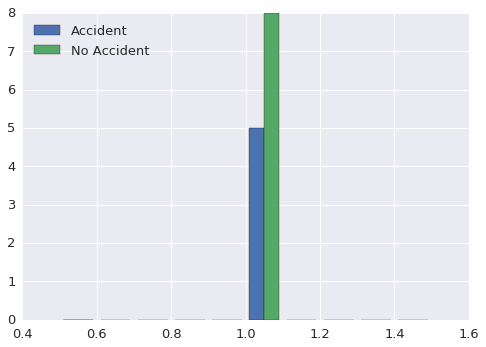

In [12]:
df = pd.DataFrame(trainRDD.collect())
print df.shape


df_rain = df[df['precip']>0]
acc = np.array(df_rain[df_rain['label']==1]['precip'])
no_acc = np.array(df_rain[df_rain['label']==0]['precip'])

print acc.shape
print no_acc.shape

fig = plt.figure()
ax = fig.add_subplot(111)

    
ax.hist([acc,no_acc],bins=10, histtype='bar',label=['Accident','No Accident'])
ax.legend(loc=2)


In [51]:
df = pd.DataFrame(trainRDD.collect())
print df.columns

Index([u'avg_aadt', u'bridges', u'dayOfMonth', u'dayOfWeek', u'fog', u'hour',
       u'id', u'label', u'liquor', u'med_aadt', u'med_speed', u'month',
       u'precip', u'rain', u'rd_cond', u'rd_count', u'road_len', u'snow',
       u'speed15', u'speed25', u'speed35', u'speed45', u'speed5', u'speed55',
       u'speed65', u'speed85', u'temp', u'tunnels', u'windspeed', u'zip_area',
       u'zipcode'],
      dtype='object')


### Baseline
Let's start with a simple baseline model based just on hour of day.

#### Test Data

In [13]:
#training data
df = pd.DataFrame(trainRDD.collect())
Y_train = np.array(df['label']) #extract the labels
X_train = df[['hour']].as_matrix()
#shuffle the training data and labels
X_train, Y_train = shuffle(X_train,Y_train,random_state=0) #shuffle the labels and features
print X_train.shape
print Y_train.shape

(211504, 1)
(211504,)


#### Test Data

In [14]:
#test data
df = pd.DataFrame(testRDD.collect())
Y_test = np.array(df['label']) #extract the labels
X_test = df[['hour']].as_matrix()
#shuffle the training data and labels
X_test, Y_test = shuffle(X_test,Y_test,random_state=0) #shuffle the labels and features
print X_test.shape
print Y_test.shape

(408996, 1)
(408996,)


### Train and Run the Model
For a model we have chosen a Random Forest which predicts a classification based on querying a "forest" of decision trees.

In [15]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=25)
rf.fit(X_train,Y_train)
training_time = time.time()
print "Training time (min) = ",1.0*(training_time-start_time)/60.0

Training time (min) =  0.0313414295514


In [45]:
#Define a function to print a ROC curve for a model
def ROC_curve(model,test_data,test_labels):
    fpr, tpr, thresholds = roc_curve(test_labels, model.predict_proba(test_data)[:,1], pos_label=1)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(fpr, tpr,label='ROC')

    x_chance = np.arange(0,1.1,0.1)
    y_chance = np.arange(0,1.1,0.1)
    plt.plot(x_chance, y_chance,label='TP=FP')

    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC Curve')
    ax.legend(loc=2)
    ax.annotate('AUC: %0.2f' %  roc_auc_score(test_labels,model.predict(test_data)), xy=(0.6, 0.4),size=20)
    ax.annotate('Accuracy: %0.2f' %  accuracy_score(test_labels,model.predict(test_data)), xy=(0.6, 0.25),size=20)

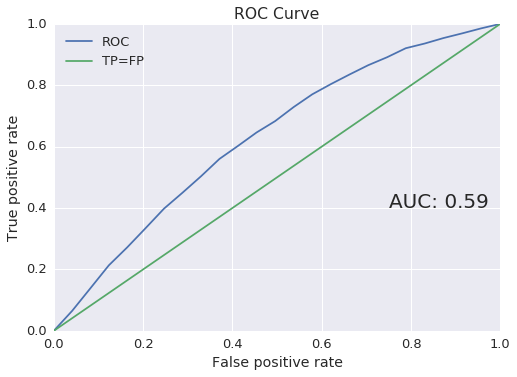

In [53]:
#print a ROC curve for the baseline model
ROC_curve(rf,X_test,Y_test)

### Add more features
Now let's add the rest of our features to the model.

#### Train Data

In [ ]:
#training data
df = pd.DataFrame(trainRDD.collect())
Y_train = np.array(df['label']) #extract the labels
df_train = df.drop(['id','label','dayOfMonth','zipcode','temp'],1)
X_train = df_train.as_matrix()
#shuffle the training data and labels
X_train, Y_train = shuffle(X_train,Y_train,random_state=0) #shuffle the labels and features
print X_train.shape
print Y_train.shape

#### Test Data

In [63]:
#test data
df = pd.DataFrame(testRDD.collect())
Y_test = np.array(df['label']) #extract the labels
df_test = df.drop(['id','label','dayOfMonth','zipcode','temp'],1)
X_test = df_test.as_matrix()
#shuffle the test data and labels
X_test, Y_test = shuffle(X_test,Y_test,random_state=0) #shuffle the labels and features
print X_test.shape
print Y_test.shape

(408996, 26)
(408996,)


In [64]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=25)#,class_weight={0:.98,1:.02})
rf.fit(X_train,Y_train)
training_time = time.time()
print "Training time (min) = ",1.0*(training_time-start_time)/60.0

Training time (min) =  0.342533866564


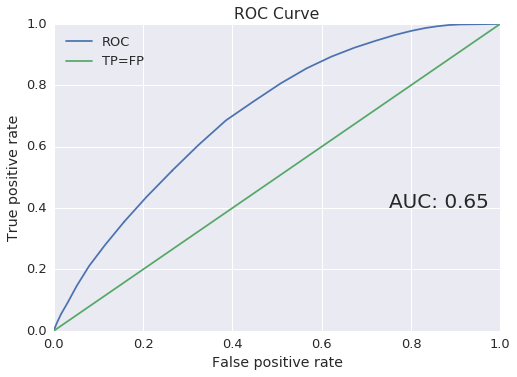

In [65]:
#print a ROC curve for the new model
ROC_curve(rf,X_test,Y_test)

Adding the rest of our features has improved the AUC score of our model. Let's see just how much those new features have added to our model.

## Feature Importance

The good thing about a Random Forest is it naturally returns a feature "importance" rating for the features in the model. Let's take a look at the feature importance ratings.

In [60]:
def feature_importance(model,features):
    #get feature importance json
    importances = model.feature_importances_
    #features = df_train.columns.values
    indices = np.argsort(importances)[::-1]

    f_sorted = zip(features[indices],importances[indices],np.arange(1,len(indices)+1))
    feature_idx = []
    for f,r,i in f_sorted:
        feature_idx.append({
                'Rank': i,
                'Feature': f,
                'Rating': r
            })

    order=features[indices]
    print order
    df = pd.DataFrame(f_sorted)
    df.columns=['Features','Rating','Rank']
    #print df
    fig = plt.figure()
    ax = sns.barplot(x="Features", y="Rating", data=df, order=order)
    ax.set_xticklabels(order,rotation='vertical',horizontalalignment='center')

['hour' 'rd_cond' 'windspeed' 'liquor' 'month' 'dayOfWeek' 'rd_count'
 'road_len' 'zip_area' 'rain' 'fog' 'speed25' 'avg_aadt' 'speed15'
 'speed35' 'med_aadt' 'speed5' 'speed65' 'speed45' 'snow' 'med_speed'
 'speed55' 'bridges' 'precip' 'speed85' 'tunnels']


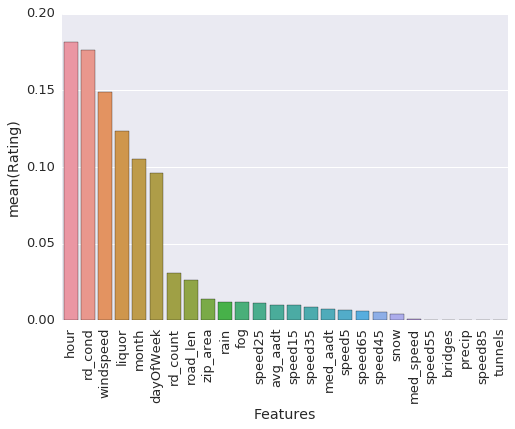

In [66]:
#get the feature importance ratings
features = df_train.columns.values
feature_importance(rf,features)

We can see that there are several features that have high importance ratings, though hour of the day is still our most important feature.

### Use Mean Decrease Accuracy instead of Impurity
Now let's add the rest of our features to the model.

#### Train Data

In [23]:
#training data
df = pd.DataFrame(trainRDD.collect())
Y_train = np.array(df['label']) #extract the labels
df_train = df.drop(['id','label','dayOfMonth'],1)
X_train = df_train.as_matrix()
#shuffle the training data and labels
X_train, Y_train = shuffle(X_train,Y_train,random_state=0) #shuffle the labels and features
print X_train.shape
print Y_train.shape

(211504, 28)
(211504,)


#### Test Data

In [24]:
#test data
df = pd.DataFrame(testRDD.collect())
Y_test = np.array(df['label']) #extract the labels
df_test = df.drop(['id','label','dayOfMonth'],1)
X_test = df_test.as_matrix()
#shuffle the test data and labels
X_test, Y_test = shuffle(X_test,Y_test,random_state=0) #shuffle the labels and features
print X_test.shape
print Y_test.shape

(408996, 28)
(408996,)


In [25]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=25,criterion='entropy')#,class_weight={0:.98,1:.02})
rf.fit(X_train,Y_train)
training_time = time.time()
print "Training time (min) = ",1.0*(training_time-start_time)/60.0

Training time (min) =  0.345178715388


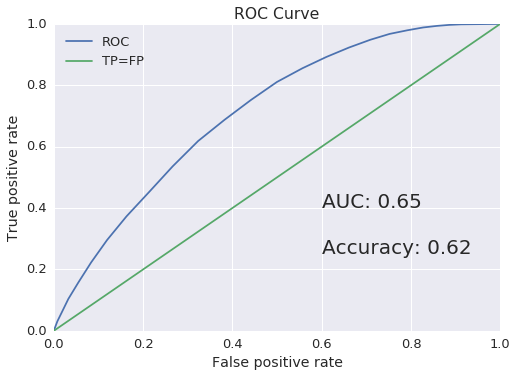

In [28]:
#print a ROC curve for the new model
ROC_curve(rf,X_test,Y_test)

Index([u'hour', u'road_len', u'rd_count', u'dayOfWeek', u'liquor', u'rd_cond',
       u'zipcode', u'zip_area', u'rain', u'med_speed', u'speed85', u'bridges',
       u'tunnels', u'precip', u'snow', u'speed55', u'speed25', u'fog',
       u'windspeed', u'speed35', u'temp', u'avg_aadt', u'speed65', u'speed15',
       u'speed5', u'speed45', u'med_aadt', u'month'],
      dtype='object')
[{'Feature': 'hour', 'Rank': 1, 'Rating': 0.075600000000000001},
 {'Feature': 'road_len', 'Rank': 2, 'Rating': 0.0206},
 {'Feature': 'rd_count', 'Rank': 3, 'Rating': 0.0132},
 {'Feature': 'dayOfWeek', 'Rank': 4, 'Rating': 0.0097999999999999997},
 {'Feature': 'liquor', 'Rank': 5, 'Rating': 0.0083999999999999995},
 {'Feature': 'rd_cond', 'Rank': 6, 'Rating': 0.0064999999999999997},
 {'Feature': 'zipcode', 'Rank': 7, 'Rating': 0.0064000000000000003},
 {'Feature': 'zip_area', 'Rank': 8, 'Rating': 0.0050000000000000001},
 {'Feature': 'rain', 'Rank': 9, 'Rating': 0.00069999999999999999},
 {'Feature': 'med_speed', '

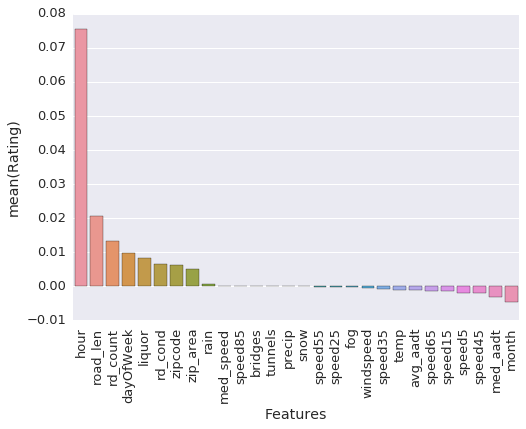

In [35]:
from pprint import pprint
pprint(mean_decrease_accuracy(rf,X_train,Y_train,df_train.columns))

### Trim Features

Let's remove some of those features that are negatively impacting accuracy.

#### Test Data

In [36]:
#training data
df = pd.DataFrame(trainRDD.collect())
Y_train = np.array(df['label']) #extract the labels
df_train = df[['hour','dayOfWeek','road_len','rd_count','rd_cond','liquor','rain','fog','snow','zip_area','zipcode']]
X_train = df_train.as_matrix()
#shuffle the training data and labels
X_train, Y_train = shuffle(X_train,Y_train,random_state=0) #shuffle the labels and features
print X_train.shape
print Y_train.shape

(211504, 11)
(211504,)


#### Train Data

In [45]:
#test data
df = pd.DataFrame(testRDD.collect())
Y_test = np.array(df['label']) #extract the labels
df_test = df[['hour','dayOfWeek','road_len','rd_count','rd_cond','liquor','rain','fog','snow','zip_area','zipcode']]
X_test = df_test.as_matrix()
#shuffle the test data and labels
X_test, Y_test = shuffle(X_test,Y_test,random_state=0) #shuffle the labels and features
print X_test.shape
print Y_test.shape

(408996, 11)
(408996,)


Training time (min) =  0.282089149952


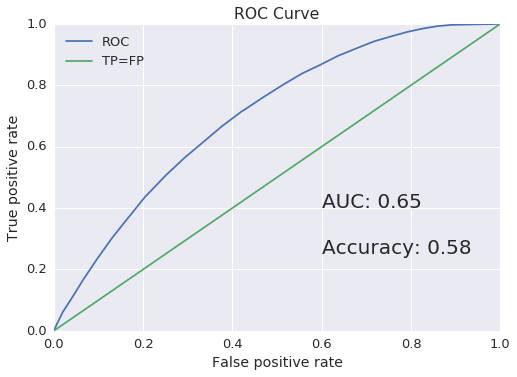

In [43]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=25,criterion='entropy')#,class_weight={0:.98,1:.02})
rf.fit(X_train,Y_train)
training_time = time.time()
print "Training time (min) = ",1.0*(training_time-start_time)/60.0

#print a ROC curve for the new model
ROC_curve(rf,X_test,Y_test)

Index([u'hour', u'road_len', u'dayOfWeek', u'rd_count', u'liquor', u'zipcode',
       u'rd_cond', u'zip_area', u'rain', u'snow', u'fog'],
      dtype='object')


[{'Feature': 'hour', 'Rank': 1, 'Rating': 0.078899999999999998},
 {'Feature': 'road_len', 'Rank': 2, 'Rating': 0.019300000000000001},
 {'Feature': 'dayOfWeek', 'Rank': 3, 'Rating': 0.016199999999999999},
 {'Feature': 'rd_count', 'Rank': 4, 'Rating': 0.012699999999999999},
 {'Feature': 'liquor', 'Rank': 5, 'Rating': 0.0121},
 {'Feature': 'zipcode', 'Rank': 6, 'Rating': 0.010999999999999999},
 {'Feature': 'rd_cond', 'Rank': 7, 'Rating': 0.0080999999999999996},
 {'Feature': 'zip_area', 'Rank': 8, 'Rating': 0.0023},
 {'Feature': 'rain', 'Rank': 9, 'Rating': 0.00069999999999999999},
 {'Feature': 'snow', 'Rank': 10, 'Rating': 0.0},
 {'Feature': 'fog', 'Rank': 11, 'Rating': -0.00069999999999999999}]

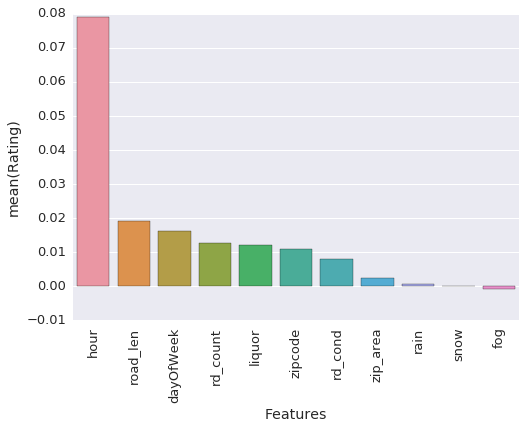

In [44]:
mean_decrease_accuracy(rf,X_train,Y_train,df_train.columns)

# Diagnostics
Before we try engineering new features, let's define a few functions to better understand how our model is performing.

In [22]:
#Custom function to calculate true/false positive/negative rates by a given cutoff probability
def custom_diagnostics(model,test_data,test_labels,cutoff=0.5):
    #adjusted predicitons based on given cutoff probability
    test_predictions = np.where(model.predict_proba(test_data)[:,1]>cutoff,np.ones(test_data.shape[0]),np.zeros(test_data.shape[0]))

    percent_accidents = np.mean(test_predictions)
    
    fp = 1.0*np.sum(np.logical_and(test_predictions==1,test_labels==0))
    false_positive_rate = fp/(np.sum(test_labels==0))
    
    tp = 1.0*np.sum(np.logical_and(test_predictions==1,test_labels==1))
    true_positive_rate = tp/(np.sum(test_labels==1))
    
    fn = 1.0*np.sum(np.logical_and(test_predictions==0,test_labels==1))
    false_negative_rate = fn/(np.sum(test_labels==1))
    
    tn = 1.0*np.sum(np.logical_and(test_predictions==0,test_labels==0))
    true_negative_rate= tn/(np.sum(test_labels==0))

    #precision = tp/(fp+tp)
    precision=precision_score(test_labels,test_predictions)
    #recall = tp/(tp+fn)
    recall=recall_score(test_labels,test_predictions)
    
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    
    #f1 = 2 * (precision*recall + 0.0)/(precision+recall)
    f1 = f1_score(test_labels,test_predictions)
    
    auc = roc_auc_score(test_labels,test_predictions)
    
    print "Percent predicted accidents: ",percent_accidents*100
    print "True positives: ",tp
    print "False positives: ",fp
    print "True negative: ",tn
    print "False Negatives: ",fn

    print "\nFalse positive rate, test data: ", false_positive_rate
    print "False negative rate, test data: ", false_negative_rate
    print "True Positive rate, test data: ", true_positive_rate
    print "True negative rate, test data: ", true_negative_rate
    
    print "Precision: ", precision
    print "Recall: ", recall
    print "Accuracy: ", accuracy
    
    print "F1: ", f1
    
    ROC_curve(model,test_data,test_labels)

    return test_predictions


Percent predicted accidents:  43.3238955882
True positives:  5068.0
False positives:  172125.0
True negative:  229754.0
False Negatives:  2049.0

False positive rate, test data:  0.428300558128
False negative rate, test data:  0.287902205986
True Positive rate, test data:  0.712097794014
True negative rate, test data:  0.571699441872
Precision:  0.0286015813266
Recall:  0.712097794014
Accuracy:  0.574142534401
F1:  0.0549943030763


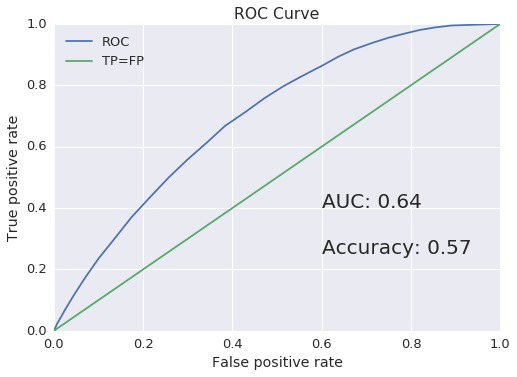

In [23]:
test_predictions = custom_diagnostics(rf,X_test,Y_test,0.5)

The overall accuracy is not bad, but we are showing a high false negative rate, which means we are missing a lot of the serious collisions in our validation data set.

## Class Weights

We purposefully sample an even split of positive and negative outcomes for our training data, however we can see in the class weights of the full grid data set that the true outcomes are greatly skewed. Sci-kit Learn's Random Forest can be trained with an initial class weight, passed as a python dictionary. Let's use the weights dictionary that was output by the training and test data function with our Random Forest.

Training time (min) =  0.285268048445
Percent predicted accidents:  49.2616064705
True positives:  5545.0
False positives:  195933.0
True negative:  205946.0
False Negatives:  1572.0

False positive rate, test data:  0.487542270186
False negative rate, test data:  0.220879584094
True Positive rate, test data:  0.779120415906
True negative rate, test data:  0.512457729814
Precision:  0.0275216152632
Recall:  0.779120415906
Accuracy:  0.517097966728
F1:  0.0531652244781


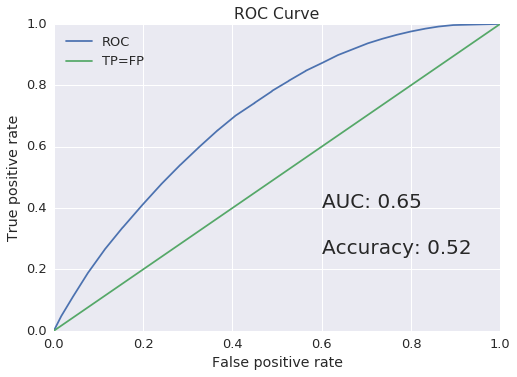

In [24]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators=25,class_weight=weights)
rf.fit(X_train,Y_train)
training_time = time.time()
print "Training time (min) = ",1.0*(training_time-start_time)/60.0

#print a ROC curve for the new model
test_predictions = custom_diagnostics(rf,X_test,Y_test,0.5)

We have dropped the overall accuracy of our model, but we have increased the AUC score and dropped the false negative rate.

## Bias-Variance Trade-off

Even though Random Forest models are not traditionally prone to overfitting, we still need to tune the parameters of our model to ensure we are not overfitting the trees.

The following cells create charts comparing the error rate of the training data versus the test data with various Random Forest parameter values with the goal of finding the parameter values that will lead to the least amount of over-fitting.

In [46]:
#Let's define a simple error rate function; concretely, the average percentage of predictions that are wrong.
def error_rate(model,X,y):
    return 1.0/(X.shape[0])*np.sum(np.where(y<>model.predict(X),np.ones(X.shape[0]),np.zeros(X.shape[0])))

### Number of trees

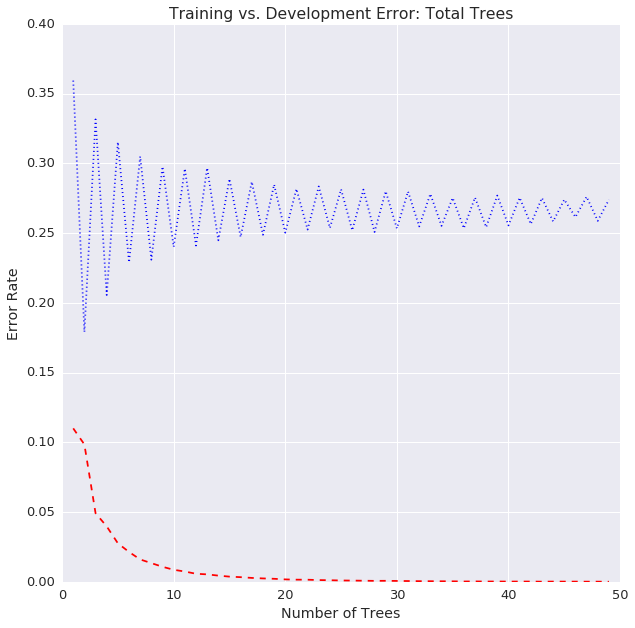

In [47]:
#iterate through several sizes of forest classifiers, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
trees=[i for i in range(1,50)]
train_acc = []
dev_acc = []
for tree in trees:
    rf = RandomForestClassifier(n_estimators=tree)
    rf.fit(X_train,Y_train)
    train_acc.append(error_rate(rf,X_train,Y_train))
    dev_acc.append(error_rate(rf,X_test,Y_test))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(trees,train_acc,'--',c='r')
ax.plot(trees,dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Number of Trees")
ax.set_title("Training vs. Development Error: Total Trees")


### Depth of Trees

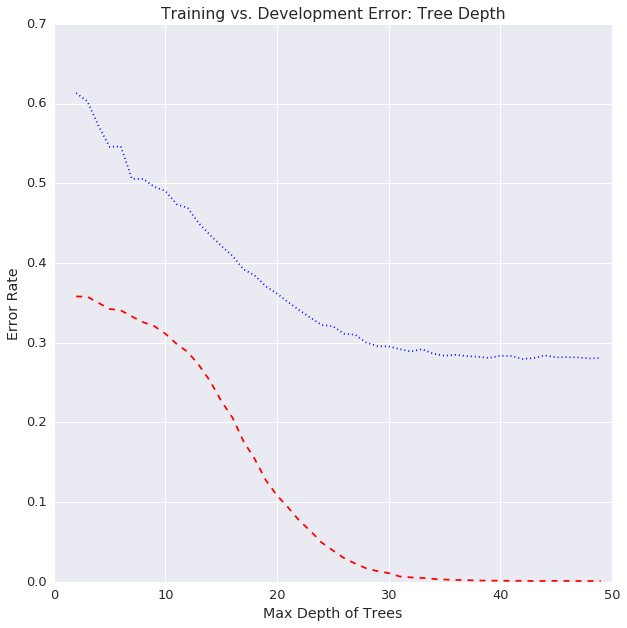

In [48]:
#iterate through several numbers of levels, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
levels = range(2,50,1)
train_acc = []
dev_acc = []
for level in levels:
    rf = RandomForestClassifier(n_estimators=25,max_depth=level)
    rf.fit(X_train,Y_train)
    train_acc.append(error_rate(rf,X_train,Y_train))
    dev_acc.append(error_rate(rf,X_test,Y_test))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(2,50,1),train_acc,'--',c='r')
ax.plot(range(2,50,1),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Max Depth of Trees")
ax.set_title("Training vs. Development Error: Tree Depth")


### Minimum Samples for a Split

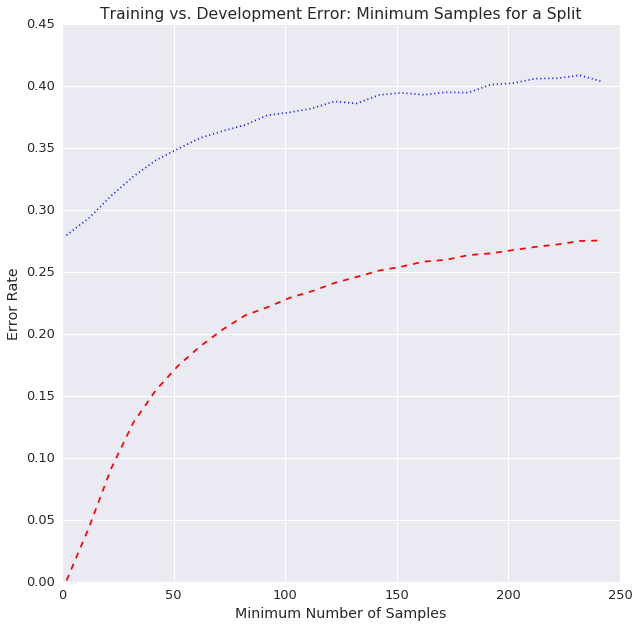

In [49]:
#iterate through several numbers of split parameters, 
#and plot the error rate of the training prediction vs. 
#the development prediction.

train_acc = []
dev_acc = []
for n in range(2,250,10):
    rf = RandomForestClassifier(n_estimators=25,min_samples_split=n)
    rf.fit(X_train,Y_train)
    train_acc.append(error_rate(rf,X_train,Y_train))
    dev_acc.append(error_rate(rf,X_test,Y_test))

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(2,250,10),train_acc,'--',c='r')
ax.plot(range(2,250,10),dev_acc,':',c='b')
ax.set_ylabel("Error Rate")
ax.set_xlabel("Minimum Number of Samples")
ax.set_title("Training vs. Development Error: Minimum Samples for a Split")


### Max Features to Find the Best Split

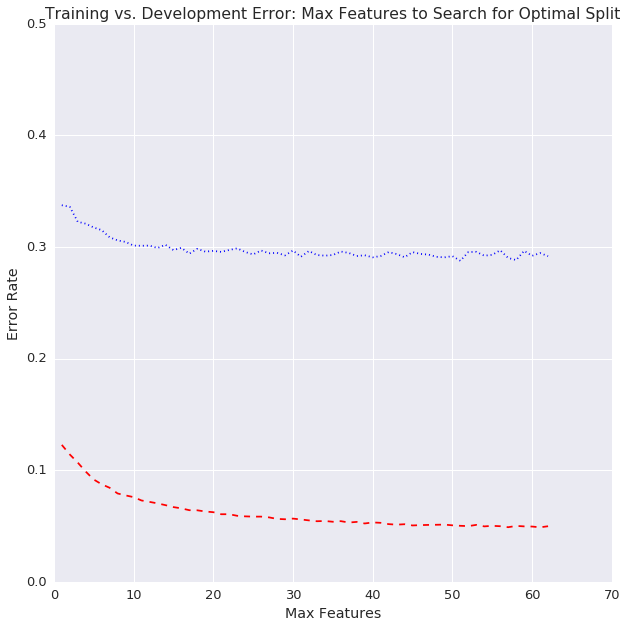

In [50]:
#iterate through several numbers of max features to search for a best split, 
#and plot the error rate of the training prediction vs. 
#the development prediction.
train_acc = []
dev_acc = []
for i in range(1,X_train.shape[1]):
    rf = RandomForestClassifier(n_estimators=25,min_samples_split=20,max_features=i)
    rf.fit(X_train,Y_train)
    train_acc.append(error_rate(rf,X_train,Y_train))
    dev_acc.append(error_rate(rf,X_test,Y_test))
    
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(range(1,X_train.shape[1]),train_acc,'--',c='r')
ax.plot(range(1,X_train.shape[1]),dev_acc,':',c='b')
ax.set_ylim((0,.5))
ax.set_ylabel("Error Rate")
ax.set_xlabel("Max Features")
ax.set_title("Training vs. Development Error: Max Features to Search for Optimal Split")


# Pulling it all Together

Now let's use the parameter tuning we've identified to improve the model.

['hour' 'rd_count' 'liquor' 'road_len' 'rd_cond' 'dayOfWeek' 'zip_area'
 'speed35' 'speed5' 'month' 'speed25' 'avg_aadt' 'speed15' 'speed65' 'rain'
 'med_aadt' 'snow' 'speed45' 'fog' 'tunnels' 'med_speed' 'speed55'
 'speed85' 'bridges']
All: 0.62
['hour' 'rd_count' 'liquor' 'road_len' 'rd_cond' 'dayOfWeek' 'zip_area'
 'speed35' 'speed5' 'speed25' 'avg_aadt' 'month' 'speed15' 'rain' 'speed65'
 'med_aadt' 'speed45' 'snow' 'med_speed' 'fog' 'tunnels' 'speed85'
 'bridges' 'speed55']
Ped: 0.63
['hour' 'rd_count' 'liquor' 'road_len' 'rd_cond' 'dayOfWeek' 'zip_area'
 'speed35' 'speed5' 'speed25' 'month' 'avg_aadt' 'speed15' 'speed65' 'rain'
 'speed45' 'med_aadt' 'fog' 'med_speed' 'tunnels' 'snow' 'speed55'
 'speed85' 'bridges']
Cyc: 0.63
['hour' 'rd_count' 'liquor' 'road_len' 'rd_cond' 'dayOfWeek' 'zip_area'
 'speed35' 'speed5' 'speed25' 'month' 'speed15' 'avg_aadt' 'speed65' 'rain'
 'med_aadt' 'speed45' 'snow' 'med_speed' 'tunnels' 'speed55' 'fog'
 'speed85' 'bridges']
Mot: 0.63


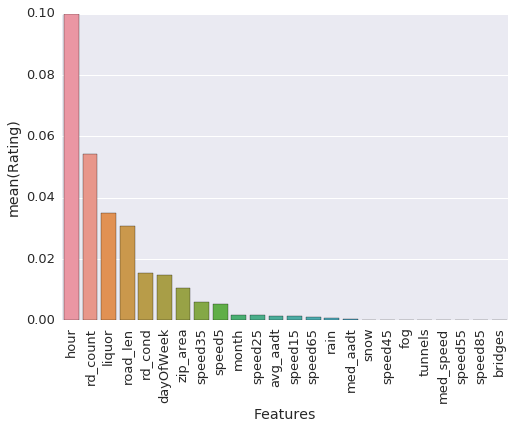

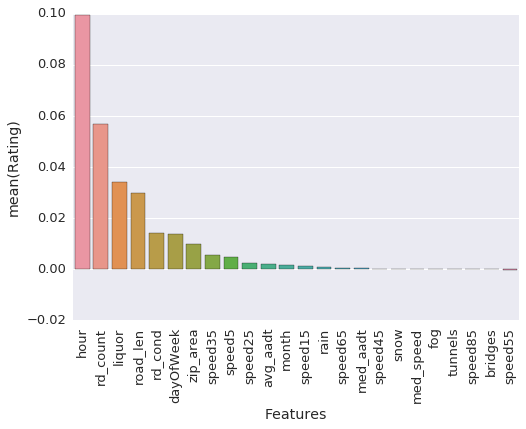

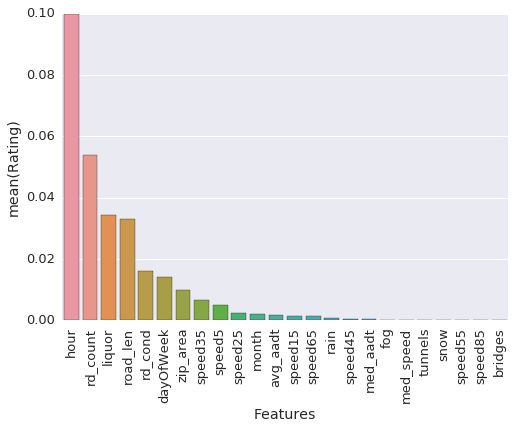

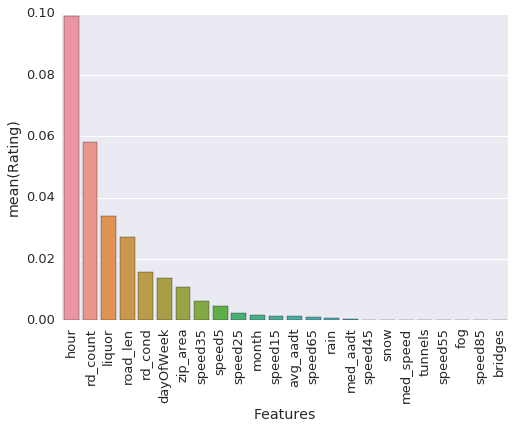

In [53]:
rf = RandomForestClassifier(n_estimators=100,min_samples_split=50,max_features=None,max_depth=15,class_weight="balanced",n_jobs=4,bootstrap=True)

#all
probabilities,all_features,all_diagnostics = fit_and_predict_model(rf,trainRDD,testRDD,predRDD,victim='all')
predictions = predictions.join(probabilities).map(lambda row: update_probability(row,victim='all'))
print "All: %01.2f" % all_diagnostics['all_Test_set_accuracy']

#pedestrian
probabilities,ped_features,ped_diagnostics = fit_and_predict_model(rf,trainRDD,testRDD,predRDD,victim='pedestrian')
predictions = predictions.join(probabilities).map(lambda row: update_probability(row,victim='pedestrian'))
print "Ped: %01.2f" % ped_diagnostics['pedestrian_Test_set_accuracy']

#cyclist
probabilities,cyc_features,cyc_diagnostics = fit_and_predict_model(rf,trainRDD,testRDD,predRDD,victim='cyclist')
predictions = predictions.join(probabilities).map(lambda row: update_probability(row,victim='cyclist'))
print "Cyc: %01.2f" % cyc_diagnostics['cyclist_Test_set_accuracy']

#motorist
probabilities,mot_features,mot_diagnostics = fit_and_predict_model(rf,trainRDD,testRDD,predRDD,victim='motorist')
predictions = predictions.join(probabilities).map(lambda row: update_probability(row,victim='motorist'))
print "Mot: %01.2f" % mot_diagnostics['motorist_Test_set_accuracy']

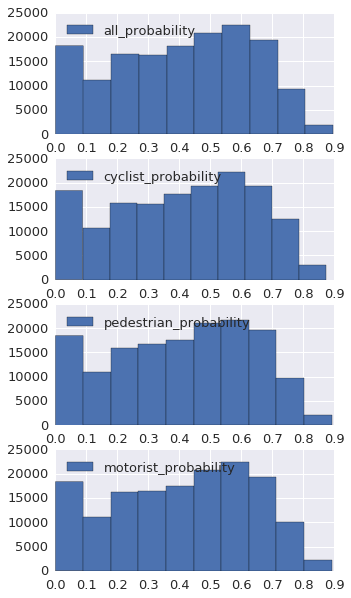

In [54]:
df = pd.DataFrame(predictions.map(lambda row: row[1]).collect())
#print df.shape
#print df.columns

fig = plt.figure(figsize=(5,10))
ax = fig.add_subplot(411)
ax.hist(df['all_probability'],bins=10, histtype='bar')
ax.legend(loc=2)

ax = fig.add_subplot(412)
ax.hist(df['cyclist_probability'],bins=10, histtype='bar')
ax.legend(loc=2)

ax = fig.add_subplot(413)
ax.hist(df['pedestrian_probability'],bins=10, histtype='bar')
ax.legend(loc=2)

ax = fig.add_subplot(414)
ax.hist(df['motorist_probability'],bins=10, histtype='bar')
ax.legend(loc=2)

## Balancing False Positives and Negatives

For a model built to predict hazardous situations it's important to err on the side of having as low a rate of false negatives as possible while still having a reasonable prediction, i.e. a reasonable rate of false positives. Simply put: we want to reduce the rate that we "miss" a collision but we also don't want to always predict a collision will occur because that is not actionable. So we will try to increase our recall (the rate of relevant items identified) while keeping a reasonable level of precision (the number of items identified that are actually relevant.)

A simple first step for this is to examine the cut-off point in our probability ratings assigned by the model to see if perhaps a 50% cutoff between relevant/non-relevant classification is not efficient for our goals.

The following formula plots the diagnostics we identified above, precision, recall, accuracy, true and false positive and negative rates, for various cut-off points. Note that the formula can take several minutes to run.

In [24]:
#Custom function to calculate true/false positive/negative rates by a given cutoff probability
def plot_pos_neg_tradeoff(model,test_data,test_labels):
    #plots true/false positive/negative rates based on cutoff points
    #cmap=plt.get_cmap('YlOrRd')
    
    cutoffs = np.arange(0.1,1,0.1)
    fp_rates = []
    tp_rates = []
    fn_rates = []
    tn_rates = []
    precision = []
    recall = []
    accuracy = []
    f1 = []
    auc = []
    
    for c in cutoffs:
        test_predictions = np.where(model.predict_proba(test_data)[:,1]>c,np.ones(test_data.shape[0]),np.zeros(test_data.shape[0]))
    
        fp = 1.0*np.sum(np.logical_and(test_predictions==1,test_labels==0))
        fp_rates.append(fp/(np.sum(test_labels==0)))

        tp = 1.0*np.sum(np.logical_and(test_predictions==1,test_labels==1))
        tp_rates.append(tp/(np.sum(test_labels==1)))

        fn = 1.0*np.sum(np.logical_and(test_predictions==0,test_labels==1))
        fn_rates.append(fn/(np.sum(test_labels==1)))

        tn = 1.0*np.sum(np.logical_and(test_predictions==0,test_labels==0))
        tn_rates.append(tn/(np.sum(test_labels==0)))

        if fp+tp>0:
            precision.append(precision_score(test_labels,test_predictions))
        else:
            precision.append(0)
        if tp+fn>0:
            recall.append(recall_score(test_labels,test_predictions))
        else:
            recall.append(0)

        accuracy.append((tp+tn)/(tp+fp+tn+fn))

        if precision[-1]+recall[-1]>0:
            f1.append(2 * (precision[-1]*recall[-1])/(precision[-1]+recall[-1]))
        else:
            f1.append(0)

        auc.append(roc_auc_score(test_labels,test_predictions))

    
    
    fig = plt.figure(figsize=(20,10))
    ax1 = fig.add_subplot(121)

    plt.plot(cutoffs,fp_rates,label='FP')
    plt.plot(cutoffs,tp_rates,label='TP')
    plt.plot(cutoffs,fn_rates,label='FN')
    plt.plot(cutoffs,tn_rates,label='TN')

    ax1.set_xlabel('Cutoff Probability')
    ax1.set_ylabel('True/False Positive/Negative Rate')
    ax1.legend(loc='upper center')
    
    ax2 = fig.add_subplot(122)

    plt.plot(cutoffs,precision,label='Precision')
    plt.plot(cutoffs,recall,label='Recall')
    plt.plot(cutoffs,accuracy,label='Accuracy')
    plt.plot(cutoffs,f1,label='F1')
    plt.plot(cutoffs,auc,label='AUC')

    ax2.set_xlabel('Cutoff Probability')
    ax2.set_ylabel('Accuracy Ratings')
    ax2.legend(loc='upper center')

    print "Max AUC %s at %s cutoff" % (np.max(auc),cutoffs[np.argmax(auc)])
    

Max AUC 0.684080964823 at 0.5 cutoff


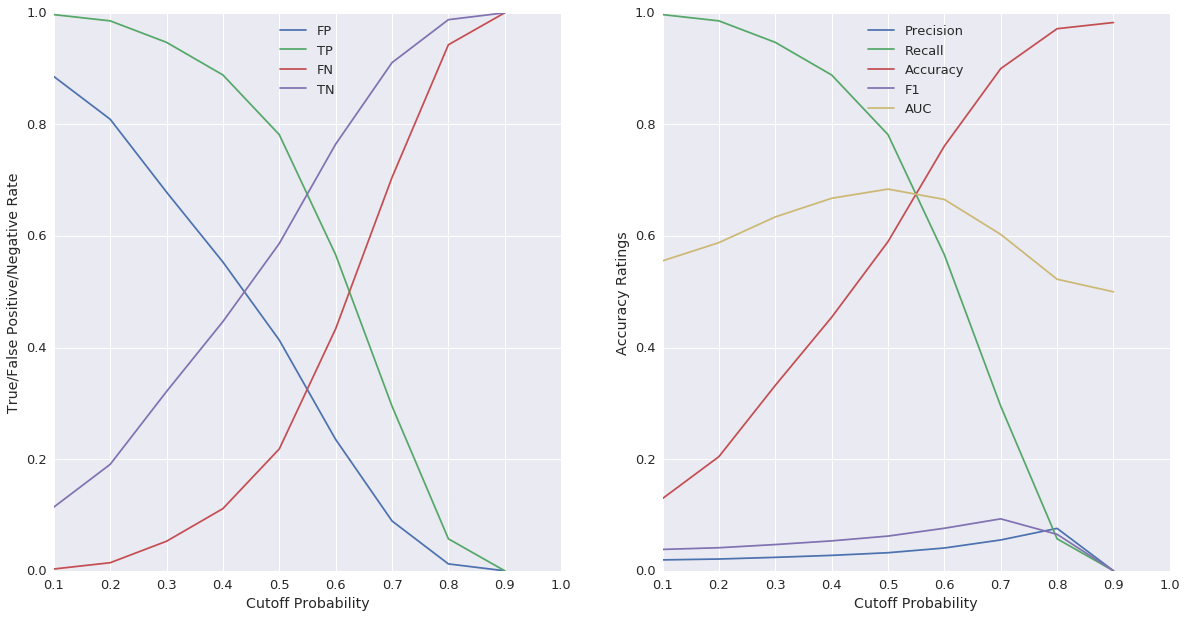

In [25]:
plot_pos_neg_tradeoff(rf,X_test,Y_test)

# Stop the Spark Context before you leave!

In [26]:
sc.stop()